In [1]:
!pip install arch yfinance > log.txt

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from arch import arch_model
import yfinance as yf
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings("ignore")

In [3]:
def get_hourly_data(name='BTC', start='2024-01-01', end='2024-10-01'):
    data = yf.download(f'{name}-USD', start=start, end=end, interval='1h')
    data['Returns'] = 100 * data['Adj Close'].pct_change().dropna()
    return data

def get_daily_data(name='BTC', start='2024-01-01', end='2024-10-01'):
    data = yf.download(f'{name}-USD', start=start, end=end)
    data['Returns'] = 100 * data['Adj Close'].pct_change().dropna()
    return data

daily_data = get_daily_data('BTC', start='2024-01-01', end='2024-10-01')
hourly_data = get_hourly_data('BTC', start='2024-01-01', end='2024-10-01')

daily_returns = daily_data['Returns'].dropna()
hourly_returns = hourly_data['Returns'].dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
def calculate_daily_realized_volatility(hourly_returns):
    daily_volatility = hourly_returns.resample('D').std()  # Daily std from hourly returns
    return daily_volatility * np.sqrt(24)

daily_realized_volatility = calculate_daily_realized_volatility(hourly_returns)

In [5]:
def get_rolling_garch_predictions(returns, model_params, window_size=100):
    vol_forecast = []
    for i in range(window_size, len(returns)):
        window_data = returns[:i]
        model = arch_model(window_data, **model_params)
        garch_fit = model.fit(disp="off", options={'maxiter': 350})
        # Forecast one-step ahead volatility
        vol_forecast.append(garch_fit.forecast(horizon=1).variance.values[-1, :][0])
    
    # Align the forecast with the returns data
    vol_forecast = pd.Series(vol_forecast, index=returns.index[window_size:])
    return np.sqrt(vol_forecast)

def get_naive_predictions(daily_realized_volatility):
    return daily_realized_volatility.shift(1)

In [6]:
def plot_predictions(realized_volatility, predictions):
    plt.figure(figsize=(12, 6))
    realized_volatility_trimmed = (realized_volatility - predictions).dropna() + predictions
    plt.plot(realized_volatility_trimmed.index, realized_volatility_trimmed, label='Realized Volatility', color='blue')
    plt.plot(predictions.index, predictions, label='Predicted Volatility', color='red')
    plt.title('Predicted vs. Realized Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility (%)')
    plt.legend()
    plt.grid()
    plt.show()
    
def plot_conic(returns, volatility):
    plt.scatter(returns, volatility)
    

def calculate_metrics(realized_volatility, predictions):
    return {
        'MSE': ((realized_volatility - predictions).dropna()**2).mean(),
        'MAE': np.abs(realized_volatility - predictions).dropna().mean()
    }

In [7]:
model_params = {'vol': 'garch', 'q': 1, 'p': 1}
garch_predictions = get_rolling_garch_predictions(daily_returns, model_params)

naive_predictions = get_naive_predictions(daily_realized_volatility)

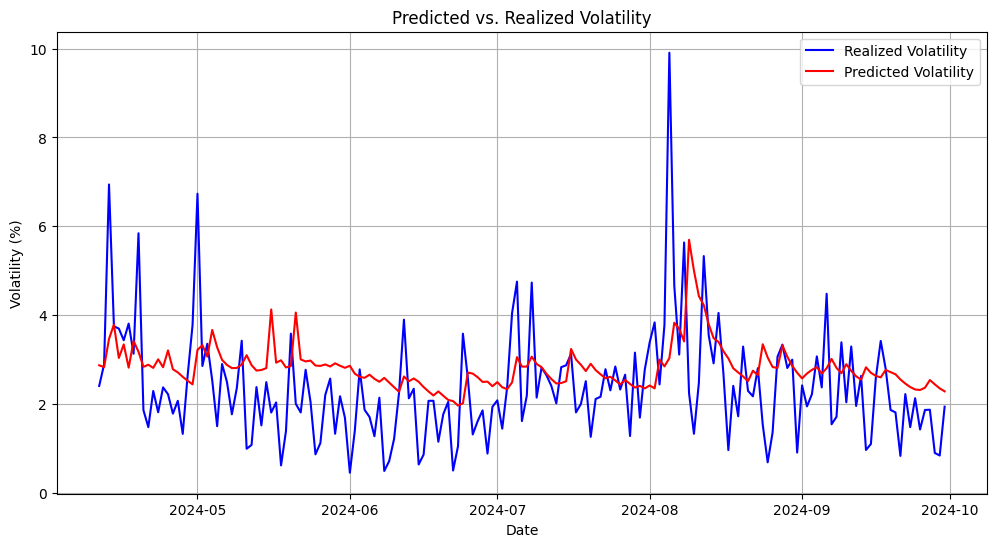

In [8]:
plot_predictions(daily_realized_volatility, garch_predictions)

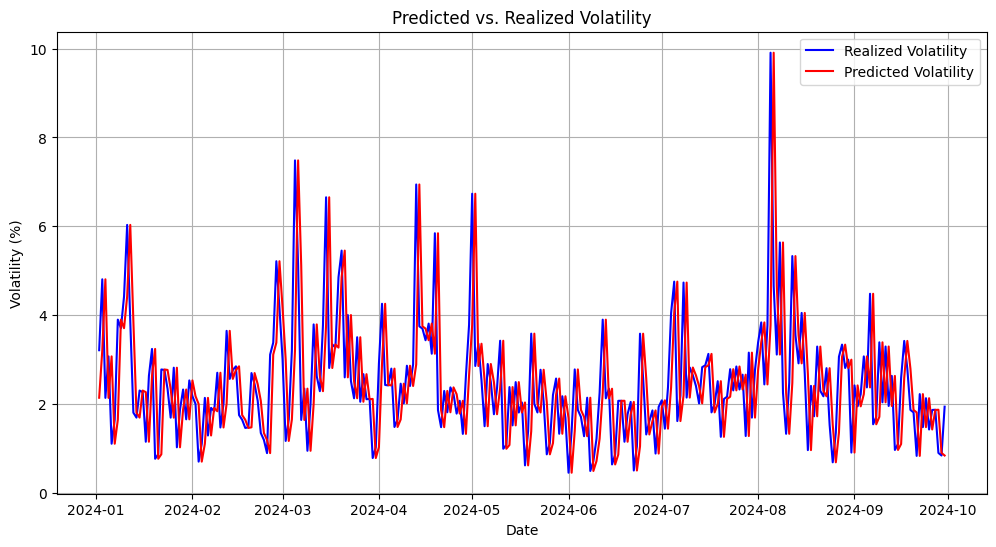

In [9]:
plot_predictions(daily_realized_volatility, naive_predictions)

In [10]:
calculate_metrics(daily_realized_volatility, garch_predictions)

{'MSE': 1.6837917790955306, 'MAE': 0.961154464807367}

In [11]:
calculate_metrics(daily_realized_volatility, naive_predictions)

{'MSE': 2.0033610370861332, 'MAE': 1.074109491869103}

In [12]:
def plot_table(data):
    table = pd.DataFrame(data, columns=["Model", "MSE", "MAE", 'MSSE', 'MASE'])
    plt.figure(figsize=(8, 4))
    sns.set(style="whitegrid")
    styled_table = table.style.background_gradient(cmap="Oranges", subset=['MSSE', 'MASE'])
    styled_table = styled_table.set_properties(**{'text-align': 'center'})
    display(styled_table)

def grid_fit_model(daily_realized_volatility, daily_returns, model_name='GARCH', dist='Normal', mse_naive=1, mae_naive=1, p_start=1, p_end=1, q_start=1, q_end=1, o_start=0, o_end=0):
    table = []
    table.append(['naive', round(mse_naive, 3), round(mae_naive, 3), 1, 1])

    for p in range(p_start, p_end+1):
        for q in range(q_start, q_end+1):
            for o in range(o_start, o_end+1):
                if model_name == 'GJR-GARCH':
                    model_params = {'vol': 'GARCH', 'q': q, 'p': p, 'o': 1, 'dist': dist}
                else:
                    model_params = {'vol': model_name, 'q': q, 'p': p, 'o': o, 'dist': dist}
                garch_predictions = get_rolling_garch_predictions(daily_returns, model_params)

                metrics = calculate_metrics(daily_realized_volatility, garch_predictions)

                mse = metrics['MSE']
                mae = metrics['MAE']
                msse = mse_naive / metrics['MSE']
                mase = mae_naive / metrics['MAE']

                table.append([f'{model_name}(p={str(p)}, q={str(q)}, o={str(o)})', mse, mae, msse, mase])

    return table

In [13]:
naive_model_metrics = calculate_metrics(daily_realized_volatility, naive_predictions)
naive_mse = naive_model_metrics['MSE']
naive_mae = naive_model_metrics['MAE']

In [14]:
garch_table = grid_fit_model(daily_realized_volatility=daily_realized_volatility,
                             daily_returns = daily_returns,
                             model_name='ARCH',
                             mse_naive=naive_mse,
                             mae_naive=naive_mae,
                             p_start=1, p_end=2, q_start=1, q_end=2)
plot_table(garch_table)

,Model,MSE,MAE,MSSE,MASE
0,naive,2.003000,1.074000,1.000000,1.000000
1,"ARCH(p=1, q=1, o=0)",1.723033,1.007503,1.162694,1.066111
2,"ARCH(p=1, q=2, o=0)",1.723033,1.007503,1.162694,1.066111
3,"ARCH(p=2, q=1, o=0)",1.742270,1.012155,1.149857,1.061211
4,"ARCH(p=2, q=2, o=0)",1.742270,1.012155,1.149857,1.061211


<Figure size 800x400 with 0 Axes>

In [15]:
garch_table = grid_fit_model(daily_realized_volatility=daily_realized_volatility,
                             daily_returns = daily_returns,
                             model_name='GARCH',
                             mse_naive=naive_mse,
                             mae_naive=naive_mae,
                             p_start=1, p_end=2, q_start=1, q_end=2)
plot_table(garch_table)

,Model,MSE,MAE,MSSE,MASE
0,naive,2.003000,1.074000,1.000000,1.000000
1,"GARCH(p=1, q=1, o=0)",1.683792,0.961154,1.189791,1.117520
2,"GARCH(p=1, q=2, o=0)",1.662774,0.959461,1.204830,1.119493
3,"GARCH(p=2, q=1, o=0)",1.701486,0.959871,1.177419,1.119015
4,"GARCH(p=2, q=2, o=0)",1.674448,0.961545,1.196431,1.117066


<Figure size 800x400 with 0 Axes>

In [16]:
garch_table = grid_fit_model(daily_realized_volatility=daily_realized_volatility,
                             daily_returns = daily_returns,
                             model_name='EGARCH',
                             mse_naive=naive_mse,
                             mae_naive=naive_mae,
                             p_start=1, p_end=2, q_start=1, q_end=2, o_start=0, o_end=1)
plot_table(garch_table)

/opt/conda/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/conda/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/conda/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/conda/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/conda/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarn

,Model,MSE,MAE,MSSE,MASE
0,naive,2.003000,1.074000,1.000000,1.000000
1,"EGARCH(p=1, q=1, o=0)",1.629218,0.951445,1.229646,1.128925
2,"EGARCH(p=1, q=1, o=1)",32684.589602,19.319723,0.000061,0.055597
3,"EGARCH(p=1, q=2, o=0)",1.617632,0.949368,1.238453,1.131394
4,"EGARCH(p=1, q=2, o=1)",inf,155003559883727601126238026261992968147518318393118171881375910747662603229244509772305586194188529125483837307834750940765427658491690320051672037982208.000000,0.000000,0.000000
5,"EGARCH(p=2, q=1, o=0)",1.623263,0.950096,1.234157,1.130527
6,"EGARCH(p=2, q=1, o=1)",1039128979689175259136376525785581005837259637374001652611285427746323588348489311067439634633350137864299425974469516256805906685416954985034098186082599117314262200153921706223482933394230722928681078052793602683812201468280989685078085079101231295635941327847356548014163888267162094861068328516263608320.000000,77501779941863800563119013130996484073759159196559085940687955373831301614622254886152793097094264562741918653917375470382713829245845160025836018991104.000000,0.000000,0.000000
7,"EGARCH(p=2, q=2, o=0)",1.656087,0.958491,1.209695,1.120626
8,"EGARCH(p=2, q=2, o=1)",363630089075147635299005209056966599867214436279815360698957509721298937814081372344428580893183414257244235723636817529146354570269399105660168132129456128.000000,45846570529714797289793100798181039697940808383300869471152881067249794809856.000000,0.000000,0.000000


<Figure size 800x400 with 0 Axes>

In [17]:
garch_table = grid_fit_model(daily_realized_volatility=daily_realized_volatility,
                             daily_returns = daily_returns,
                             model_name='GJR-GARCH',
                             mse_naive=naive_mse,
                             mae_naive=naive_mae,
                             p_start=1, p_end=3, q_start=1, q_end=3)
plot_table(garch_table)

,Model,MSE,MAE,MSSE,MASE
0,naive,2.003000,1.074000,1.000000,1.000000
1,"GJR-GARCH(p=1, q=1, o=0)",1.597921,0.952335,1.253730,1.127869
2,"GJR-GARCH(p=1, q=2, o=0)",1.532725,0.948623,1.307058,1.132283
3,"GJR-GARCH(p=1, q=3, o=0)",1.585038,0.923448,1.263920,1.163151
4,"GJR-GARCH(p=2, q=1, o=0)",1.657399,0.960472,1.208738,1.118314
5,"GJR-GARCH(p=2, q=2, o=0)",1.541714,0.951470,1.299437,1.128894
6,"GJR-GARCH(p=2, q=3, o=0)",1.672926,0.933167,1.197519,1.151036
7,"GJR-GARCH(p=3, q=1, o=0)",1.623081,0.948186,1.234295,1.132805
8,"GJR-GARCH(p=3, q=2, o=0)",1.546399,0.951792,1.295500,1.128513
9,"GJR-GARCH(p=3, q=3, o=0)",1.697746,0.942973,1.180012,1.139067


<Figure size 800x400 with 0 Axes>

In [18]:
garch_table = grid_fit_model(daily_realized_volatility=daily_realized_volatility,
                             daily_returns = daily_returns,
                             model_name='APARCH',
                             mse_naive=naive_mse,
                             mae_naive=naive_mae,
                             p_start=1, p_end=2, q_start=1, q_end=2, o_start=0, o_end=1)
plot_table(garch_table)

/opt/conda/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/conda/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/conda/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/conda/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/conda/lib/python3.10/site-packag

,Model,MSE,MAE,MSSE,MASE
0,naive,2.003000,1.074000,1.000000,1.000000
1,"APARCH(p=1, q=1, o=0)",192874996.663708,1056.832817,0.000000,0.001016
2,"APARCH(p=1, q=1, o=1)",18249.400935,11.862602,0.000110,0.090546
3,"APARCH(p=1, q=2, o=0)",1.608603,0.966477,1.245404,1.111366
4,"APARCH(p=1, q=2, o=1)",5894306751.495252,5838.461973,0.000000,0.000184
5,"APARCH(p=2, q=1, o=0)",6.142325,1.166219,0.326157,0.921019
6,"APARCH(p=2, q=1, o=1)",314459.829563,45.476568,0.000006,0.023619
7,"APARCH(p=2, q=2, o=0)",3864.368087,8.672821,0.000518,0.123848
8,"APARCH(p=2, q=2, o=1)",107180466256.311951,24914.170200,0.000000,0.000043


<Figure size 800x400 with 0 Axes>

In [19]:
garch_table = grid_fit_model(daily_realized_volatility=daily_realized_volatility,
                             daily_returns = daily_returns,
                             model_name='FIGARCH',
                             mse_naive=naive_mse,
                             mae_naive=naive_mae,
                             p_start=0, p_end=1, q_start=0, q_end=1, o_start=0, o_end=1)
plot_table(garch_table)

ValueError: p and q must be either 0 or 1.

kL

In [20]:
rel = (daily_returns.values / daily_realized_volatility[1:].values)

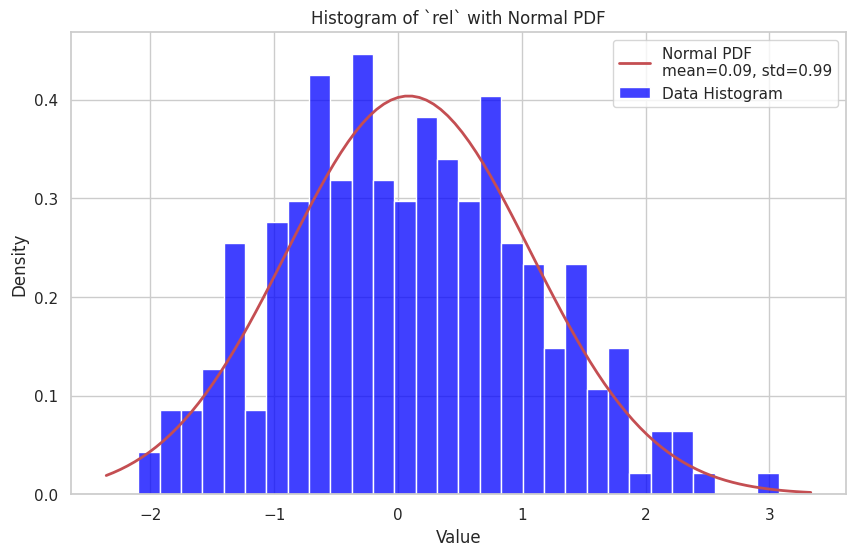

<Figure size 600x600 with 0 Axes>

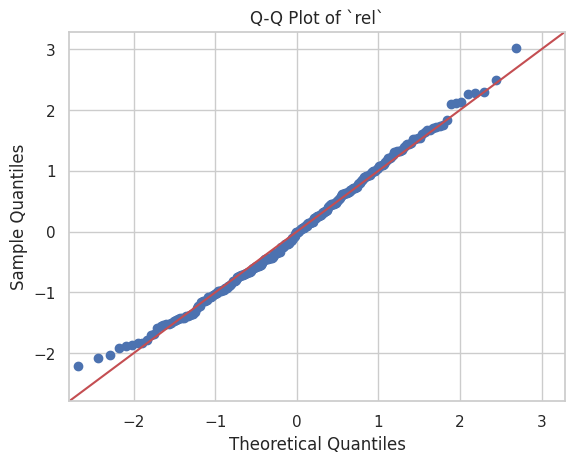

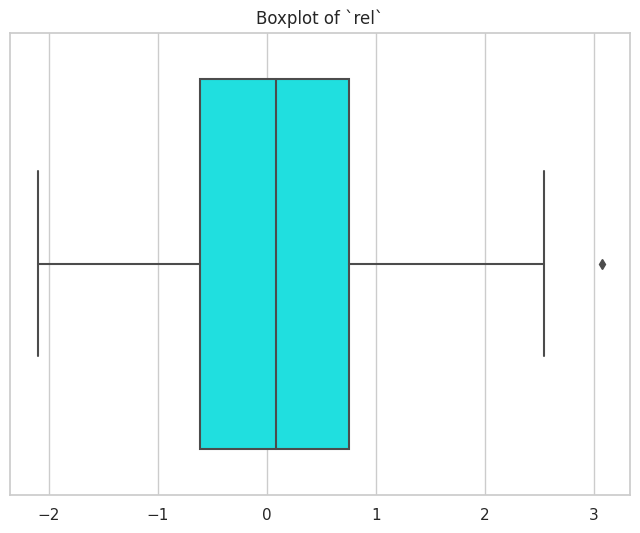

Shapiro-Wilk Test: Statistic=0.9921, p-value=0.1533
Anderson-Darling Test: Statistic=0.4748
At 15.0% significance level: Critical value=0.5680
At 10.0% significance level: Critical value=0.6470
At 5.0% significance level: Critical value=0.7760
At 2.5% significance level: Critical value=0.9050
At 1.0% significance level: Critical value=1.0770
Kolmogorov-Smirnov Test: Statistic=0.0487, p-value=0.5214


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# Assume `rel` is already defined as a numpy array
# You can generate some sample data to simulate `rel`
# rel = np.random.randn(1000)  # Normally distributed data

# 1(a) Plot histogram of `rel` and overlay the normal PDF
plt.figure(figsize=(10, 6))

# Histogram of 'rel'
sns.histplot(rel, bins=30, kde=False, color='blue', stat='density', label='Data Histogram')

# Overlay normal PDF
mean, std = np.mean(rel), np.std(rel)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
pdf = stats.norm.pdf(x, mean, std)
plt.plot(x, pdf, 'r', linewidth=2, label=f'Normal PDF\nmean={mean:.2f}, std={std:.2f}')

plt.legend()
plt.title("Histogram of `rel` with Normal PDF")
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

# 1(b) Q-Q Plot to compare data quantiles to normal quantiles
plt.figure(figsize=(6, 6))
sm.qqplot(rel, line='45', fit=True)
plt.title("Q-Q Plot of `rel`")
plt.show()

# (Optional) Other illustrative plots like boxplots or density plots
plt.figure(figsize=(8, 6))
sns.boxplot(x=rel, color='cyan')
plt.title("Boxplot of `rel`")
plt.show()

# 2(a) Shapiro-Wilk Test for normality
shapiro_stat, shapiro_p = stats.shapiro(rel)
print(f"Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")

# 2(b) Anderson-Darling Test for normality
anderson_stat = stats.anderson(rel)
print(f"Anderson-Darling Test: Statistic={anderson_stat.statistic:.4f}")
for i, critical_value in enumerate(anderson_stat.critical_values):
    sig_level = anderson_stat.significance_level[i]
    print(f"At {sig_level}% significance level: Critical value={critical_value:.4f}")

# 2(c) Kolmogorov-Smirnov Test for normality
ks_stat, ks_p = stats.kstest(rel, 'norm', args=(mean, std))
print(f"Kolmogorov-Smirnov Test: Statistic={ks_stat:.4f}, p-value={ks_p:.4f}")
